In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import lightgbm as lgbm
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform
import numpy as np
from sklearn.metrics import r2_score
from helper import *
from make_features import *
from helper_lgbm import *
loc_data = '/Users/yuxuan/Desktop/kaggle_optiver/optiver-realized-volatility-prediction'

In [8]:
df_train = pd.read_csv(f'{loc_data}/workingdata_train.csv', index_col = 0)

In [9]:
X = df_train.drop(columns = ['stock_id', 'time_id', 'target'])
y = df_train.target

In [10]:
X.shape, y.shape

((340844, 212), (340844,))

In [11]:
X.head()

,book.seconds_in_bucket.count,book.wap1.sum,book.wap1.mean,book.wap1.std,book.wap2.sum,book.wap2.mean,book.wap2.std,book.log_return1.sum,book.log_return1.realized_volatility,book.log_return1.mean,...,trade_450.size.sum,trade_450.order_count.mean,trade_300.log_return.realized_volatility,trade_300.seconds_in_bucket.count,trade_300.size.sum,trade_300.order_count.mean,trade_150.log_return.realized_volatility,trade_150.seconds_in_bucket.count,trade_150.size.sum,trade_150.order_count.mean
0,302,303.125061,1.003725,0.000693,303.105539,1.003661,0.000781,0.002292,0.004499,7.613599e-06,...,1042.0,2.642857,0.001308,21.0,1587.0,2.571429,0.001701,30.0,2069.0,2.433333
1,200,200.047768,1.000239,0.000262,200.041171,1.000206,0.000272,0.000360,0.001204,1.810239e-06,...,828.0,2.200000,0.000587,16.0,900.0,2.250000,0.000813,24.0,1173.0,2.041667
2,188,187.913849,0.999542,0.000864,187.939824,0.999680,0.000862,-0.002074,0.002369,-1.109201e-05,...,1085.0,3.666667,0.001137,12.0,1189.0,3.166667,0.001621,20.0,2010.0,2.950000
3,120,119.859781,0.998832,0.000757,119.835941,0.998633,0.000656,-0.002828,0.002574,-2.376661e-05,...,514.0,3.666667,0.001089,9.0,1556.0,5.111111,0.001401,11.0,1631.0,4.545455
4,176,175.932865,0.999619,0.000258,175.934256,0.999626,0.000317,-0.000002,0.001894,-1.057099e-08,...,43.0,3.500000,0.000453,11.0,1219.0,4.909091,0.000550,16.0,1570.0,4.500000


In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, 
                                                    random_state = 101)
eval_set = [(X_eval, y_eval)]

best score
OrderedDict([('l2', 1.5089385102619183e-06), ('R2', 0.81583), ('RMSPE', 0.28708)])
[lgbm run]  32.522sec


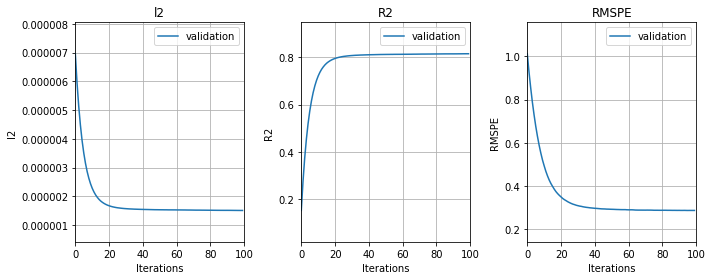

In [16]:
# default
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
             n_estimators = 100,
             learning_rate = 0.1,
             random_state = 101
            )

best score
OrderedDict([('l2', 1.4567033987632042e-06), ('R2', 0.82221), ('RMSPE', 0.28092)])
[lgbm run]  167.683sec


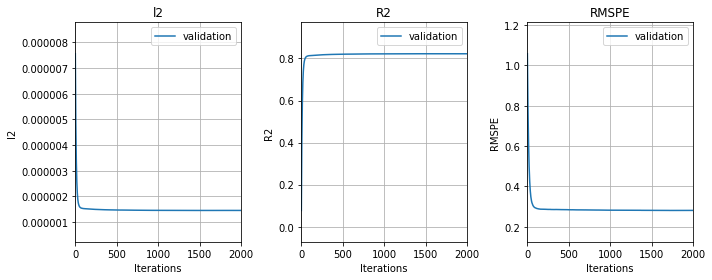

In [18]:
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
             n_estimators = 2000,
             learning_rate = 0.05,
             random_state = 101
            )

best score
OrderedDict([('l2', 1.45731100425623e-06), ('R2', 0.82214), ('RMSPE', 0.28218)])
[lgbm run]  463.050sec


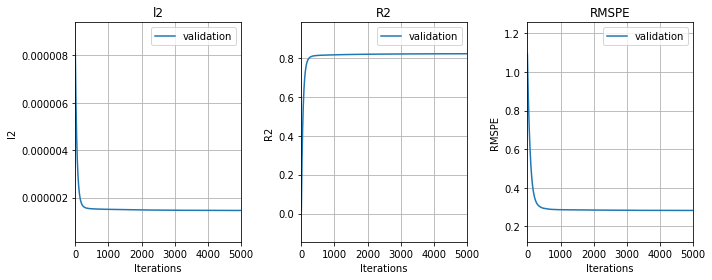

In [19]:
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
             n_estimators = 5000,
             learning_rate = 0.01,
             random_state = 101
            )

In [24]:
# distributions = {'learning_rate' = uniform(loc = 0.01, scale = 0.19),
#                  'feature_fraction' = uniform(loc = 0.3, scale = 0.8),
#                  'max_depth' = np.arange(3, 11),
#                  'min_data_in_leaf' = np.arange(3000, 21000, 1000),
#                  'num_leaves' = 
#                  'min_gain_to_split' = 
#                 }

distributions = {'learning_rate' : uniform(loc = 0.01, scale = 0.19),
                 'colsample_bytree' : uniform(loc = 0.3, scale = 0.6),
                 'max_depth' : np.arange(4, 11),
                 'min_child_samples' : np.arange(3000, 21000, 2000),
                 'num_leaves' : np.arange(30, 930, 50),
                }

In [25]:
reg = lgbm.LGBMRegressor(n_estimators = 2000)

In [29]:
clf = RandomizedSearchCV(reg, distributions, 
                         n_iter = 10,
                         random_state=0, n_jobs=-1)

with timer('lgbm random search 5CV'):
    search = clf.fit(X, y)

[lgbm random search 5CV]  4727.518sec


In [31]:
cv_r = pd.DataFrame(search.cv_results_)

In [39]:
cv_r.mean_test_score.max(), cv_r.mean_test_score.min()

(0.8158536682132176, 0.7878545225006441)

In [40]:
len(cv_r)

10

In [34]:
clf = RandomizedSearchCV(reg, distributions, 
                         n_iter = 20,
                         random_state=0, n_jobs=-1)

with timer('lgbm random search 5CV'):
    search = clf.fit(X, y)

[lgbm random search 5CV]  8846.125sec


In [35]:
cv_r_longer = pd.DataFrame(search.cv_results_)

In [38]:
cv_r_longer.mean_test_score.max(), cv_r_longer.mean_test_score.min()

(0.8158536682132176, 0.7878545225006441)

In [41]:
len(cv_r_longer)

20